In [1]:
import pandas as pd
import numpy as np

from numpy import array

import matplotlib.pyplot as plt

import statsmodels.api as sm

In [4]:
def find_c0(dat, aa, C26_col, C29_col, C31_col):
  mat = np.empty((3,3), float)
  k = 2*np.pi/10.4
  n = array([26, 29, 31])
  mat[0:3, 0] = 1
  mat[0:3, 1] = np.sin(n*k)
  mat[0:3, 2] = np.cos(n*k)
  mat[0, 1:3] = mat[0, 1:3]*aa[0]
  mat[1, 1:3] = mat[1, 1:3]*aa[1]
  mat[2, 1:3] = mat[2, 1:3]*aa[2]
  inv_mat = np.linalg.inv(mat)
  c0A1A2 = array(np.matmul(dat[[C26_col, C29_col, C31_col]], np.transpose(inv_mat))).astype(float)
  c0Aphi = c0A1A2
  c0Aphi[:,0] = c0A1A2[:,0]
  c0Aphi[:,1] = np.sqrt(c0A1A2[:,1]**2 + c0A1A2[:,2]**2)
  c0Aphi[:,2] <- np.sign(c0A1A2[:,2]) * np.arccos(c0A1A2[:,1]/c0Aphi[:,1])
  return c0Aphi[:,0]

In [5]:
training_data_name = "tiling"

In [3]:
genome_df_tiling = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/tiling_full_reconstructed.csv")

In [4]:
genome_df_tiling.shape

(578880, 10)

In [11]:
genome_df_tiling["C26_norm"] = (genome_df_tiling["C26"] - genome_df_tiling["C26"].mean())/genome_df_tiling["C26"].std()
genome_df_tiling["C29_norm"] = (genome_df_tiling["C29"] - genome_df_tiling["C29"].mean())/genome_df_tiling["C29"].std()
genome_df_tiling["C31_norm"] = (genome_df_tiling["C31"] - genome_df_tiling["C31"].mean())/genome_df_tiling["C31"].std()
genome_df_tiling["C0_orig_norm"] = (genome_df_tiling["C0_orig"] - genome_df_tiling["C0_orig"].mean())/genome_df_tiling["C0_orig"].std()

In [12]:
cn_avg_pred_df = pd.read_csv(f"/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/ir_lstm_cn_{training_data_name}_tiling_full_reconstructed_predictions.csv")

In [13]:
genome_df_tiling = pd.concat([genome_df_tiling, cn_avg_pred_df], axis=1)

In [14]:
pred_C26 = array(genome_df_tiling["n=26"])
pred_C29 = array(genome_df_tiling["n=29"])
pred_C31 = array(genome_df_tiling["n=31"])
pred_C0 = array(genome_df_tiling["C0"])

aa1 = [1,1,1]
aa2 = [1, 1/0.82, 1/0.7]
aa3 = [1, 0.72, 1.06]
aa4 = [1, 1/0.886, 1/0.81]

In [15]:
C26_C29_corr = []
C26_C31_corr = []
C29_C31_corr = []

half_window_size_list = range(1,11)
window_size_array = array(half_window_size_list)*2 + 1
# smooth_cn_df = pd.DataFrame(columns=["smooth_" + str(i) + "bp_" + j for i in window_size_array for j in ["C26", "C29", "C31", "C01", "C02"]])
smooth_cn_df = pd.DataFrame(columns=["smooth_" + str(i) + "bp_" + j for i in window_size_array for j in ["C26", "C29", "C31"]])

for half_window_size in half_window_size_list:
    print(f"Begin half window size {half_window_size}")

    smooth_C26 = [np.mean(pred_C26[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_tiling.shape[0]-half_window_size)]
    smooth_C29 = [np.mean(pred_C29[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_tiling.shape[0]-half_window_size)]
    smooth_C31 = [np.mean(pred_C31[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_tiling.shape[0]-half_window_size)]
    # C26_C29_corr.append(np.corrcoef(smooth_C26, smooth_C29)[0,1])
    # C26_C31_corr.append(np.corrcoef(smooth_C26, smooth_C31)[0,1])
    # C29_C31_corr.append(np.corrcoef(smooth_C29, smooth_C31)[0,1])
    for i in range(half_window_size):
        smooth_C26.append(np.nan)
        smooth_C26.insert(0, np.nan)
        smooth_C29.append(np.nan)
        smooth_C29.insert(0, np.nan)
        smooth_C31.append(np.nan)
        smooth_C31.insert(0, np.nan)
    
    
    for i in range(half_window_size):
        # for j in range(i,len(smooth_C26),1952):
        for j in range(i,len(smooth_C26),1005):
            # Make first half_window_size values in each gene NaN:
            smooth_C26[j] = np.nan
            smooth_C29[j] = np.nan
            smooth_C31[j] = np.nan
        # for j in range(1951-i,len(smooth_C26),1952):
        for j in range(1004-i,len(smooth_C26),1005):
            # Make last half_window_size values in each gene NaN:
            smooth_C26[j] = np.nan
            smooth_C29[j] = np.nan
            smooth_C31[j] = np.nan

        # smooth_C26[range(i,len(smooth_C26), 1952)] = np.nan
        # smooth_C26[range(1951-i,len(smooth_C26), 1952)] = np.nan

        # smooth_C29[range(i,len(smooth_C29), 1952)] = np.nan
        # smooth_C29[range(1951-i,len(smooth_C29), 1952)] = np.nan

        # smooth_C31[range(i,len(smooth_C31), 1952)] = np.nan
        # smooth_C31[range(1951-i,len(smooth_C31), 1952)] = np.nan


    C26_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C26"
    C29_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C29"
    C31_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C31"
    smooth_cn_df[C26_col] = smooth_C26
    smooth_cn_df[C29_col] = smooth_C29
    smooth_cn_df[C31_col] = smooth_C31

    smooth_cn_corr = smooth_cn_df[[C26_col, C29_col, C31_col]].corr()
    C26_C29_corr.append(smooth_cn_corr.iloc[0,1])
    C26_C31_corr.append(smooth_cn_corr.iloc[0,2])
    C29_C31_corr.append(smooth_cn_corr.iloc[1,2])

    smooth_C01 = find_c0(smooth_cn_df, aa1, C26_col, C29_col, C31_col)
    # smooth_C02 = find_c0(smooth_cn_df, aa2, C26_col, C29_col, C31_col)
    smooth_cn_df["smooth_" + str(half_window_size*2 + 1) + "bp_C01"] = smooth_C01





    # smooth_C26 = []
    # smooth_C29 = []
    # smooth_C31 = []
    # for gene_number in range(576):
    #     print(f"\tBegin gene {gene_number}")
    #     smooth_C26.extend([np.mean(pred_C26[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)])
    #     smooth_C29.extend([np.mean(pred_C29[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)])
    #     smooth_C31.extend([np.mean(pred_C31[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)])
    #     for i in range(half_window_size):
    #         smooth_C26.append(np.nan)
    #         smooth_C26.insert(gene_number*1952, np.nan)
    #         smooth_C29.append(np.nan)
    #         smooth_C29.insert(gene_number*1952, np.nan)
    #         smooth_C31.append(np.nan)
    #         smooth_C31.insert(gene_number*1952, np.nan)
    # C26_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C26"
    # C29_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C29"
    # C31_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C31"
    # smooth_cn_df[C26_col] = smooth_C26
    # smooth_cn_df[C29_col] = smooth_C29
    # smooth_cn_df[C31_col] = smooth_C31
    # print(smooth_cn_df)
    # smooth_cn_corr = smooth_cn_df[[C26_col, C29_col, C31_col]].corr()
    # C26_C29_corr.append(smooth_cn_corr.iloc[0,1])
    # C26_C31_corr.append(smooth_cn_corr.iloc[0,2])
    # C29_C31_corr.append(smooth_cn_corr.iloc[1,2])

    # smooth_C01 = find_c0(smooth_cn_df, aa1, C26_col, C29_col, C31_col)
    # # smooth_C02 = find_c0(smooth_cn_df, aa2, C26_col, C29_col, C31_col)
    # smooth_cn_df["smooth_" + str(half_window_size*2 + 1) + "bp_C01"] = smooth_C01
    # # smooth_cn_df["smooth_" + str(half_window_size*2 + 1) + "bp_C02"] = smooth_C02

    # # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C26"] = pred_C26 - array(smooth_C26, dtype=float)
    # # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C29"] = pred_C29 - array(smooth_C29, dtype=float)
    # # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C31"] = pred_C31 - array(smooth_C31, dtype=float)

    # # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C01"] = pred_C0 - smooth_C01
    # # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C02"] = pred_C0 - smooth_C02
    

Begin half window size 1
Begin half window size 2
Begin half window size 3
Begin half window size 4
Begin half window size 5
Begin half window size 6
Begin half window size 7
Begin half window size 8
Begin half window size 9
Begin half window size 10


In [16]:
genome_df_tiling = pd.concat([genome_df_tiling, smooth_cn_df], axis=1)

In [17]:
genome_df_tiling.columns

Index(['sequence', 'gene_number', 'direction', 'chr', 'region_pos', 'chr_pos',
       'C26', 'C29', 'C31', 'C0_orig', 'C26_norm', 'C29_norm', 'C31_norm',
       'C0_orig_norm', 'n=26', 'n=29', 'n=31', 'C0', 'smooth_3bp_C26',
       'smooth_3bp_C29', 'smooth_3bp_C31', 'smooth_5bp_C26', 'smooth_5bp_C29',
       'smooth_5bp_C31', 'smooth_7bp_C26', 'smooth_7bp_C29', 'smooth_7bp_C31',
       'smooth_9bp_C26', 'smooth_9bp_C29', 'smooth_9bp_C31', 'smooth_11bp_C26',
       'smooth_11bp_C29', 'smooth_11bp_C31', 'smooth_13bp_C26',
       'smooth_13bp_C29', 'smooth_13bp_C31', 'smooth_15bp_C26',
       'smooth_15bp_C29', 'smooth_15bp_C31', 'smooth_17bp_C26',
       'smooth_17bp_C29', 'smooth_17bp_C31', 'smooth_19bp_C26',
       'smooth_19bp_C29', 'smooth_19bp_C31', 'smooth_21bp_C26',
       'smooth_21bp_C29', 'smooth_21bp_C31', 'smooth_3bp_C01',
       'smooth_5bp_C01', 'smooth_7bp_C01', 'smooth_9bp_C01', 'smooth_11bp_C01',
       'smooth_13bp_C01', 'smooth_15bp_C01', 'smooth_17bp_C01',
       'sm

In [18]:
C26_corr = [genome_df_tiling[["n=26", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array]
C29_corr = [genome_df_tiling[["n=29", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array]
C31_corr = [genome_df_tiling[["n=31", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array]

C26_C0_corr = [genome_df_tiling[["C0", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array]
C29_C0_corr = [genome_df_tiling[["C0", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array]
C31_C0_corr = [genome_df_tiling[["C0", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array]

C01_C0_corr = [genome_df_tiling[["C0", f"smooth_{i}bp_C01"]].corr().values[0,1] for i in window_size_array]
# C02_C0_corr = [genome_df_tiling[["C0", f"smooth_{i}bp_C02"]].corr().values[0,1] for i in window_size_array]

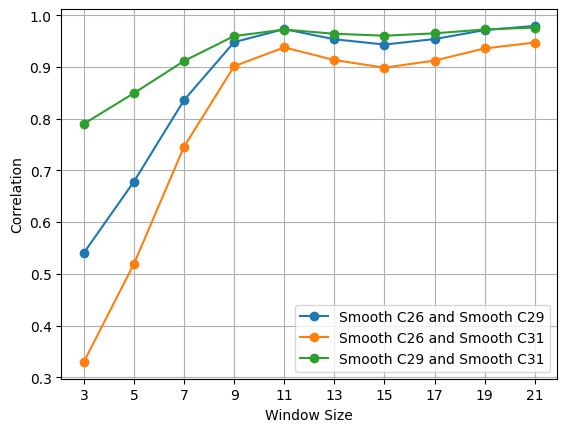

In [19]:
plt.plot(window_size_array, C26_C29_corr, marker="o", label="Smooth C26 and Smooth C29")
plt.plot(window_size_array, C26_C31_corr, marker="o", label="Smooth C26 and Smooth C31")
plt.plot(window_size_array, C29_C31_corr, marker="o", label="Smooth C29 and Smooth C31")
plt.legend()
plt.xlabel("Window Size")
plt.ylabel("Correlation")
plt.xticks(window_size_array)
plt.grid()
plt.show()

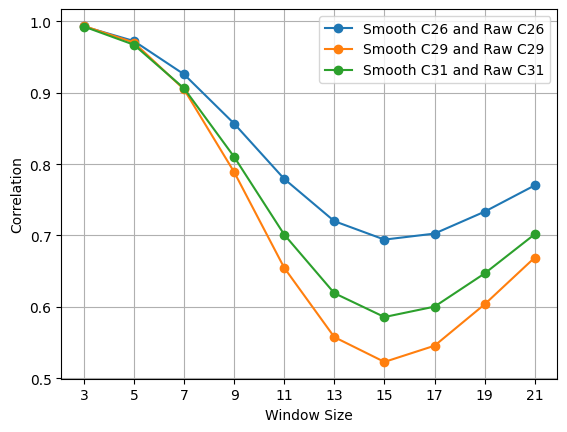

In [20]:
plt.plot(window_size_array, C26_corr, marker="o", label="Smooth C26 and Raw C26")
plt.plot(window_size_array, C29_corr, marker="o", label="Smooth C29 and Raw C29")
plt.plot(window_size_array, C31_corr, marker="o", label="Smooth C31 and Raw C31")
plt.legend()
plt.xlabel("Window Size")
plt.ylabel("Correlation")
plt.xticks(window_size_array)
plt.grid()
plt.show()

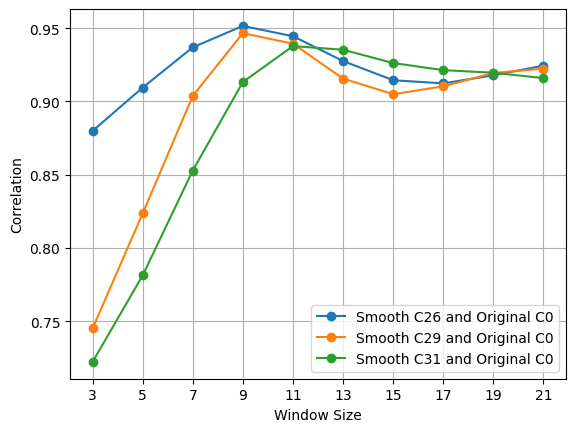

In [21]:
plt.plot(window_size_array, C26_C0_corr, marker="o", label="Smooth C26 and Original C0")
plt.plot(window_size_array, C29_C0_corr, marker="o", label="Smooth C29 and Original C0")
plt.plot(window_size_array, C31_C0_corr, marker="o", label="Smooth C31 and Original C0")
plt.legend()
plt.xlabel("Window Size")
plt.ylabel("Correlation")
plt.xticks(window_size_array)
plt.grid()
plt.show()

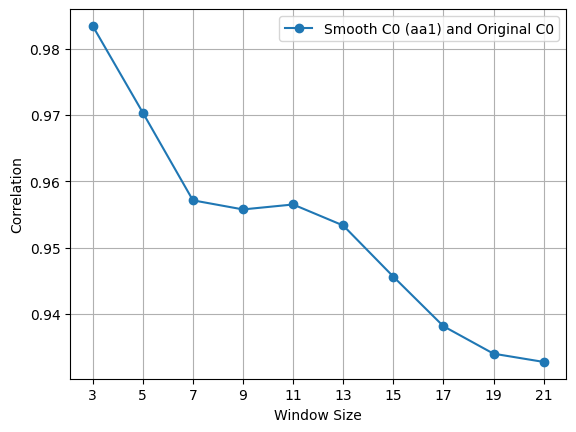

In [22]:
plt.plot(window_size_array, C01_C0_corr, marker="o", label="Smooth C0 (aa1) and Original C0")
# plt.plot(window_size_array, C02_C0_corr, marker="o", label="Smooth C0 (aa2) and Original C0")
plt.legend()
plt.xlabel("Window Size")
plt.ylabel("Correlation")
plt.xticks(window_size_array)
plt.grid()
plt.show()

In [23]:
C26_C29_corr_refined = []
C26_C31_corr_refined = []
C29_C31_corr_refined = []

window_size_array_refined = array([x/10 for x in range(90, 131)])
smooth_cn_df_refined = pd.DataFrame(columns=["smooth_" + str(i) + "bp_" + j for i in window_size_array for j in ["C26", "C29", "C31"]])

for window_size in window_size_array_refined:
    print(f"Begin window size {window_size}")
    floor_window_size = int(np.floor(window_size) - ((np.floor(window_size)-1)%2))
    ceil_window_size = int(np.ceil(window_size) + ((np.ceil(window_size)-1)%2))

    cur_C26_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C26"]
    cur_C26_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C26"]
    cur_C29_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C29"]
    cur_C29_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C29"]
    cur_C31_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C31"]
    cur_C31_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C31"]

    if floor_window_size == ceil_window_size:
        w_floor = w_ceil = 1
    else:
        w_floor = 1/(window_size-floor_window_size)
        w_ceil = 1/(ceil_window_size-window_size)

    smooth_C26 = array((cur_C26_floor*w_floor + cur_C26_ceil*w_ceil)/(w_floor + w_ceil))
    smooth_C29 = array((cur_C29_floor*w_floor + cur_C29_ceil*w_ceil)/(w_floor + w_ceil))
    smooth_C31 = array((cur_C31_floor*w_floor + cur_C31_ceil*w_ceil)/(w_floor + w_ceil))

    # C26_C29_corr_refined.append(np.corrcoef(smooth_C26[((ceil_window_size-1)//2):(len(smooth_C26) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C29[((ceil_window_size-1)//2):(len(smooth_C29) - ((ceil_window_size-1)//2))])[0,1])
    # C26_C31_corr_refined.append(np.corrcoef(smooth_C26[((ceil_window_size-1)//2):(len(smooth_C26) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C31[((ceil_window_size-1)//2):(len(smooth_C31) - ((ceil_window_size-1)//2))])[0,1])
    # C29_C31_corr_refined.append(np.corrcoef(smooth_C29[((ceil_window_size-1)//2):(len(smooth_C29) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C31[((ceil_window_size-1)//2):(len(smooth_C31) - ((ceil_window_size-1)//2))])[0,1])
    
    C26_col = "smooth_" + str(window_size) + "bp_C26"
    C29_col = "smooth_" + str(window_size) + "bp_C29"
    C31_col = "smooth_" + str(window_size) + "bp_C31"

    smooth_cn_df_refined[C26_col] = smooth_C26
    smooth_cn_df_refined[C29_col] = smooth_C29
    smooth_cn_df_refined[C31_col] = smooth_C31

    smooth_cn_corr_refined = smooth_cn_df_refined[[C26_col, C29_col, C31_col]].corr()
    C26_C29_corr_refined.append(smooth_cn_corr_refined.iloc[0,1])
    C26_C31_corr_refined.append(smooth_cn_corr_refined.iloc[0,2])
    C29_C31_corr_refined.append(smooth_cn_corr_refined.iloc[1,2])

    smooth_cn_mean = smooth_cn_df_refined[[C26_col, C29_col, C31_col]].mean(axis=1)
    smooth_cn_mean2 = smooth_cn_df_refined[[C26_col, C31_col]].mean(axis=1)
    # C31_weight = 0.8
    # smooth_cn_mean3 = ((smooth_cn_df_refined[C26_col] + C31_weight*smooth_cn_df_refined[C31_col])/(1+C31_weight))[5:-5]

    smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
    smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean3"] = smooth_cn_mean3

    smooth_C01 = find_c0(smooth_cn_df_refined, aa1, C26_col, C29_col, C31_col)
    smooth_C02 = find_c0(smooth_cn_df_refined, aa2, C26_col, C29_col, C31_col)
    # smooth_C03 = find_c0(smooth_cn_df_refined, aa3, C26_col, C29_col, C31_col)
    # smooth_C04 = find_c0(smooth_cn_df_refined, aa4, C26_col, C29_col, C31_col)

    smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C01"] = smooth_C01
    smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C02"] = smooth_C02
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C03"] = smooth_C03
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C04"] = smooth_C04

    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C26"] = pred_C26 - array(smooth_C26, dtype=float)
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C29"] = pred_C29 - array(smooth_C29, dtype=float)
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C31"] = pred_C31 - array(smooth_C31, dtype=float)

    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C01"] = pred_C0 - smooth_C01
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C02"] = pred_C0 - smooth_C02

Begin window size 9.0
Begin window size 9.1
Begin window size 9.2
Begin window size 9.3
Begin window size 9.4
Begin window size 9.5
Begin window size 9.6
Begin window size 9.7
Begin window size 9.8
Begin window size 9.9
Begin window size 10.0
Begin window size 10.1
Begin window size 10.2
Begin window size 10.3
Begin window size 10.4


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined[C29_col] = smooth_C29
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined[C31_col] = smooth_C31
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

Begin window size 10.5


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 10.6


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 10.7


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 10.8


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 10.9


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.0


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.1


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.2


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.3


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.4


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.5


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.6


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.7


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.8


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 11.9


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.0


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.1


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.2


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.3


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.4


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.5


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.6


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.7


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.8


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 12.9


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

Begin window size 13.0


/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_34354/3374834117.py:64: PerformanceWarning: DataF

In [24]:
genome_df_tiling = pd.concat([genome_df_tiling, smooth_cn_df_refined], axis=1)

In [25]:
C26_corr_refined = [genome_df_tiling[["n=26", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array_refined]
C29_corr_refined = [genome_df_tiling[["n=29", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array_refined]
C31_corr_refined = [genome_df_tiling[["n=31", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array_refined]

C26_C0_corr_refined = [genome_df_tiling[["C0", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array_refined]
C29_C0_corr_refined = [genome_df_tiling[["C0", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array_refined]
C31_C0_corr_refined = [genome_df_tiling[["C0", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array_refined]

C01_C0_corr_refined = [genome_df_tiling[["C0", f"smooth_{i}bp_C01"]].corr().values[0,1] for i in window_size_array_refined]
C02_C0_corr_refined = [genome_df_tiling[["C0", f"smooth_{i}bp_C02"]].corr().values[0,1] for i in window_size_array_refined]

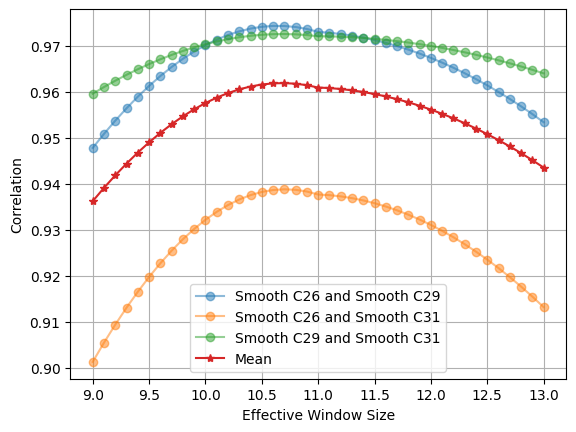

In [26]:
avg_correlation = [np.mean([C26_C29_corr_refined[i], C26_C31_corr_refined[i], C29_C31_corr_refined[i]]) for i in range(len(window_size_array_refined))]
alpha_val1 = 0.5
alpha_val2 = 1
plt.plot(window_size_array_refined, C26_C29_corr_refined, marker="o", label="Smooth C26 and Smooth C29", alpha=alpha_val1)
plt.plot(window_size_array_refined, C26_C31_corr_refined, marker="o", label="Smooth C26 and Smooth C31", alpha=alpha_val1)
plt.plot(window_size_array_refined, C29_C31_corr_refined, marker="o", label="Smooth C29 and Smooth C31", alpha=alpha_val1)
plt.plot(window_size_array_refined, avg_correlation, marker="*", label="Mean", alpha=alpha_val2)
plt.legend()
plt.xlabel("Effective Window Size")
plt.ylabel("Correlation")
# plt.ylim([.85, 1])
plt.grid()
plt.show()

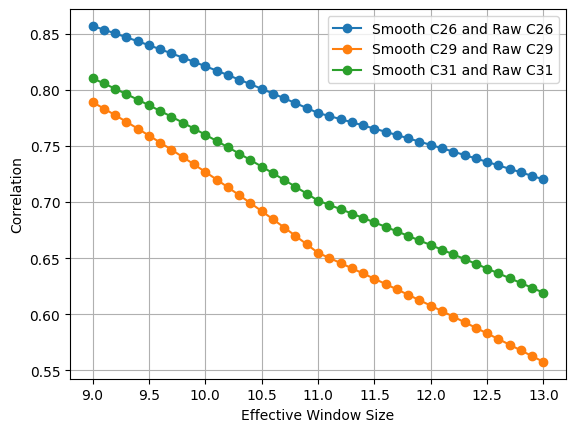

In [27]:
plt.plot(window_size_array_refined, C26_corr_refined, marker="o", label="Smooth C26 and Raw C26")
plt.plot(window_size_array_refined, C29_corr_refined, marker="o", label="Smooth C29 and Raw C29")
plt.plot(window_size_array_refined, C31_corr_refined, marker="o", label="Smooth C31 and Raw C31")
plt.legend()
plt.xlabel("Effective Window Size")
plt.ylabel("Correlation")
plt.grid()
plt.show()

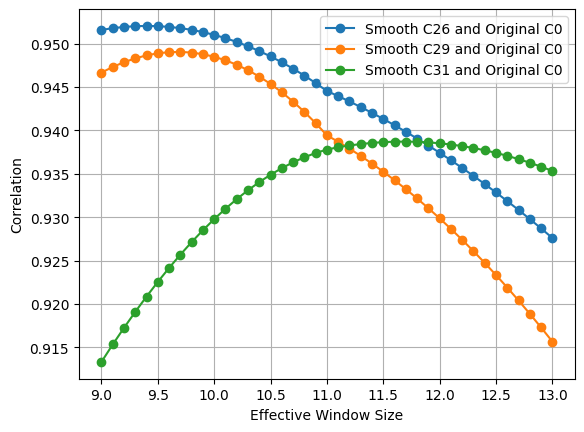

In [28]:
plt.plot(window_size_array_refined, C26_C0_corr_refined, marker="o", label="Smooth C26 and Original C0")
plt.plot(window_size_array_refined, C29_C0_corr_refined, marker="o", label="Smooth C29 and Original C0")
plt.plot(window_size_array_refined, C31_C0_corr_refined, marker="o", label="Smooth C31 and Original C0")
plt.legend()
plt.xlabel("Effective Window Size")
plt.ylabel("Correlation")
plt.grid()
plt.show()

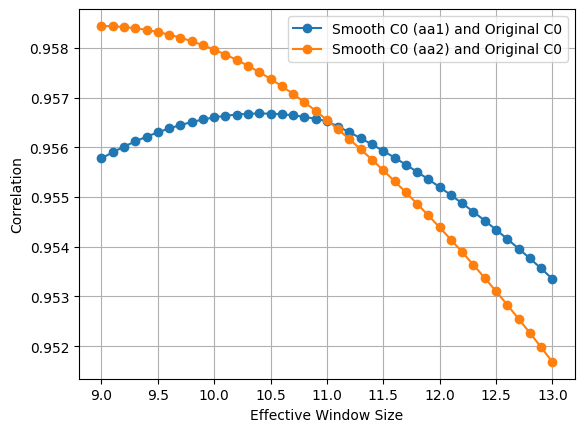

In [29]:
plt.plot(window_size_array_refined, C01_C0_corr_refined, marker="o", label="Smooth C0 (aa1) and Original C0")
plt.plot(window_size_array_refined, C02_C0_corr_refined, marker="o", label="Smooth C0 (aa2) and Original C0")
plt.legend()
plt.xlabel("Effective Window Size")
plt.ylabel("Correlation")
plt.grid()
plt.show()

In [30]:
window_size_array_refined[np.where(avg_correlation == max(avg_correlation))]

array([10.7])

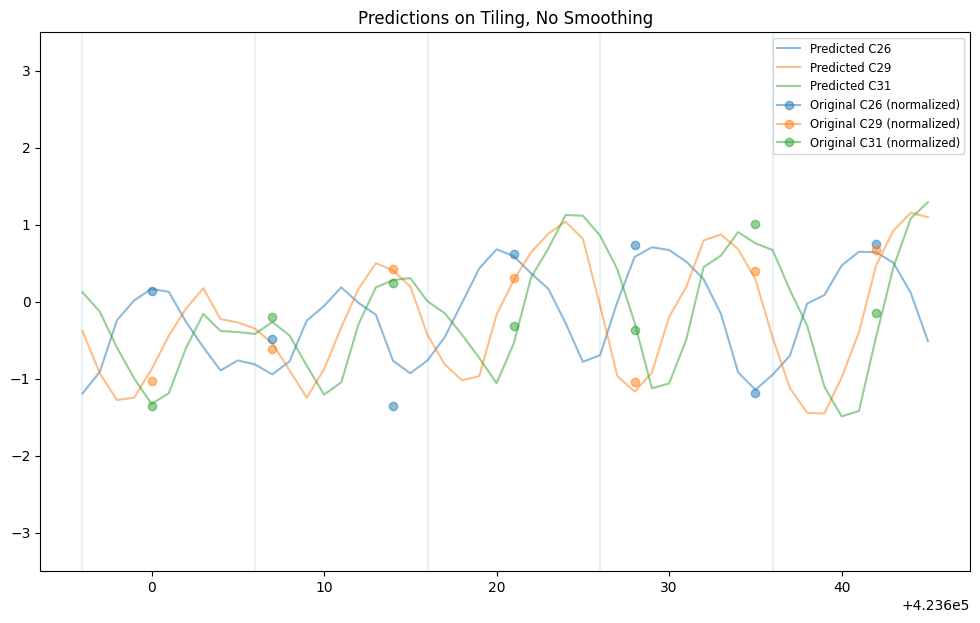

In [41]:
sequence_length = 50
# sequence_length = 100
# sequence_length = 147
# sequence_length = 200
# sequence_length = 2000

gene_number = np.random.randint(576)
ingene_starting_point = np.random.randint(1005-sequence_length)

starting_point = starting_point = gene_number*1005 + ingene_starting_point

alpha_val = 0.5
# alpha_val = 0.3
alpha_val_2 = 0.4
alpha_val_3 = 0.5
alpha_val_4 = 0.5

# ylims=[-3, 3]
ylims=[-3.5, 3.5]

plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_tiling["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val, color="C0")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_tiling["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val, color="C1")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_tiling["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val, color="C2")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_tiling["C0"][range(starting_point, starting_point + sequence_length)], label="Predicted C0", alpha=alpha_val_4)

# plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_tiling.C0[range(starting_point, starting_point + sequence_length)]) if x is not None],
#          [x for x in genome_df_tiling.C0[range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C0", alpha=alpha_val_2, marker="o")
plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_tiling.C26[range(starting_point, starting_point + sequence_length)]) if x is not None],
         [x for x in genome_df_tiling["C26_norm"][range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C26 (normalized)", alpha=alpha_val_3, marker="o")
plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_tiling.C29[range(starting_point, starting_point + sequence_length)]) if x is not None],
         [x for x in genome_df_tiling["C29_norm"][range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C29 (normalized)", alpha=alpha_val_3, marker="o")
plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_tiling.C31[range(starting_point, starting_point + sequence_length)]) if x is not None],
         [x for x in genome_df_tiling["C31_norm"][range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C31 (normalized)", alpha=alpha_val_3, marker="o")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          ((genome_df_tiling["n=26"] + genome_df_tiling["n=31"])/2)[range(starting_point, starting_point + sequence_length)], label="Predicted C26 - C31", alpha=alpha_val, color="C4")

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, No Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

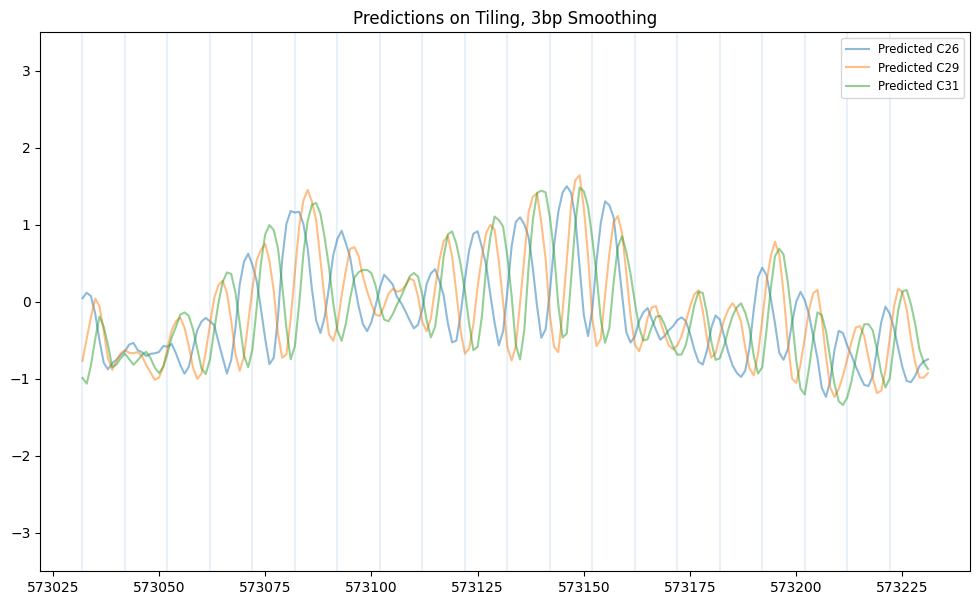

In [109]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_3bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_3bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_3bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val)


plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 3bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

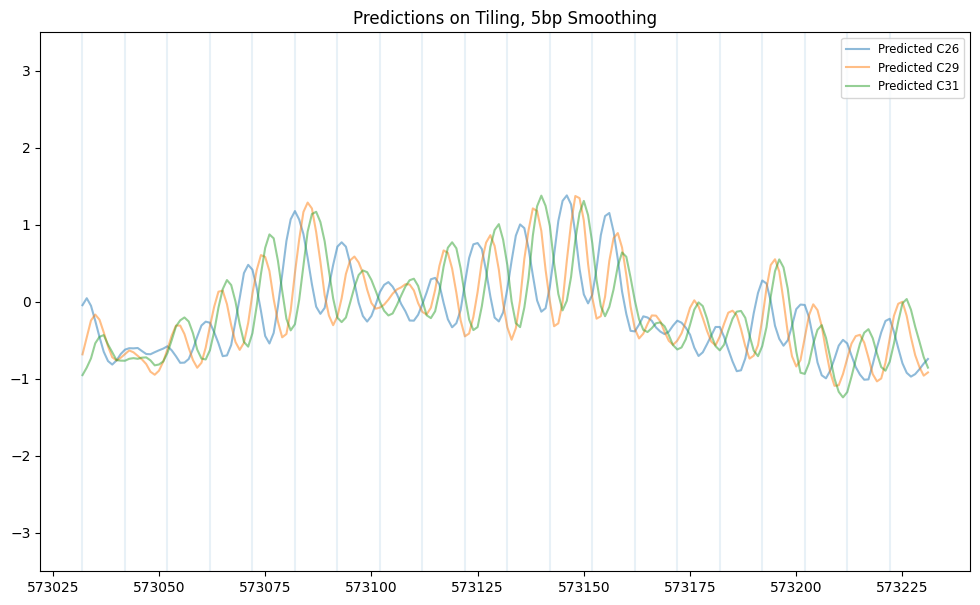

In [110]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_5bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_5bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_5bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_5bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_5bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 5bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

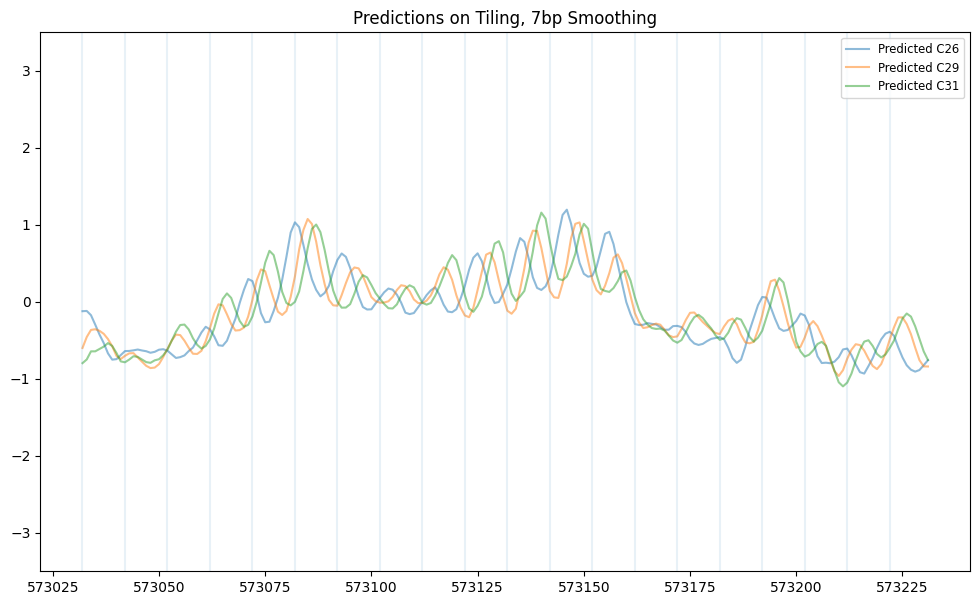

In [111]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 7bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

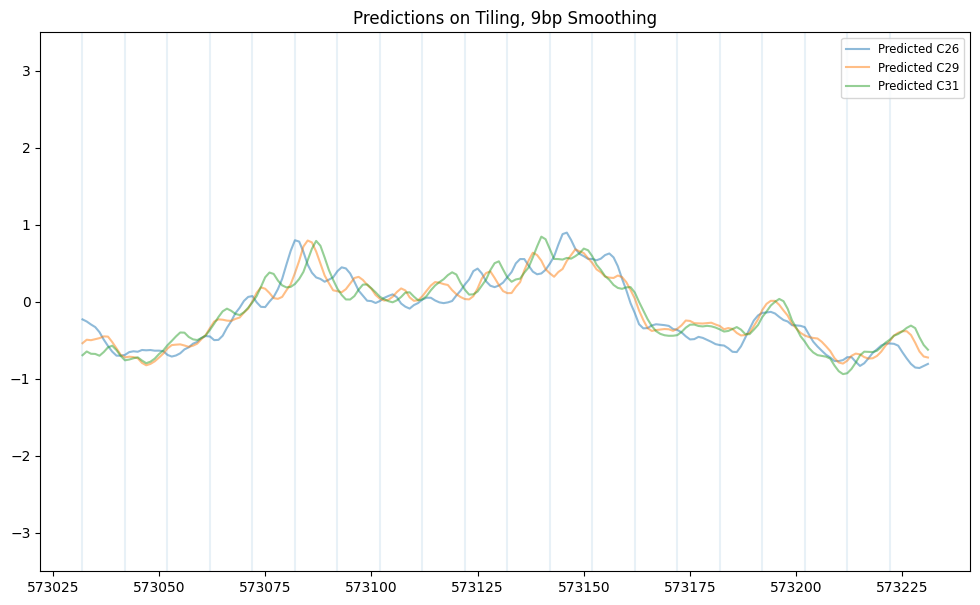

In [112]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_9bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_9bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_9bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_9bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_9bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 9bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

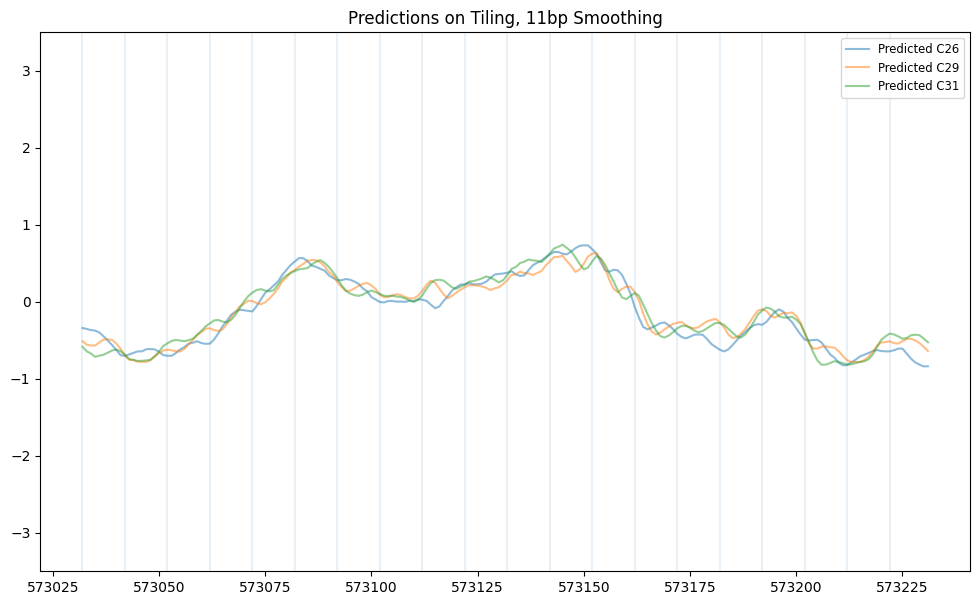

In [113]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 11bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


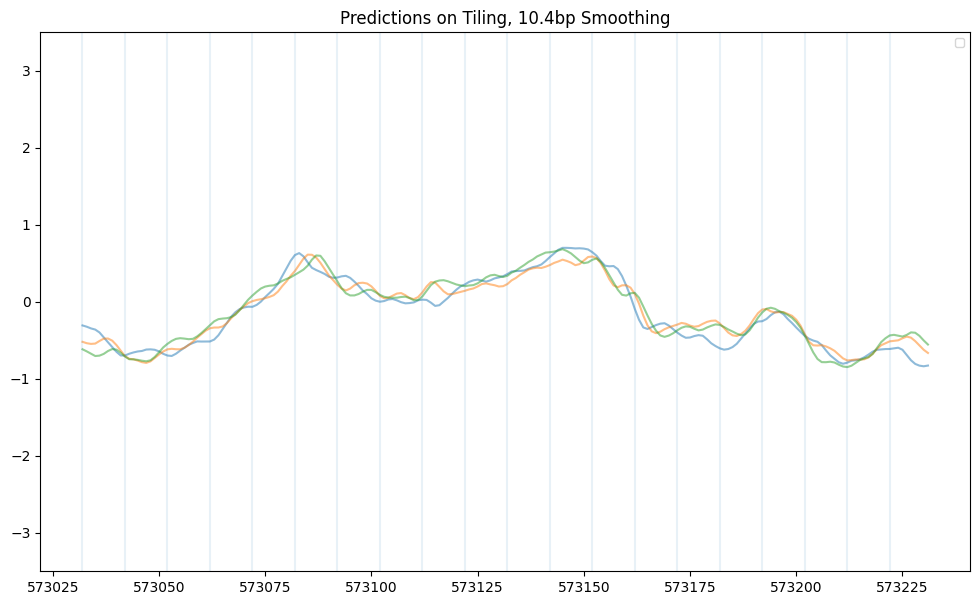

In [114]:
plt.figure(figsize=(12,7))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val, color="C0")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val, color="C1")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val, color="C2")

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C26"][range(starting_point, starting_point + sequence_length)], alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C29"][range(starting_point, starting_point + sequence_length)], alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C31"][range(starting_point, starting_point + sequence_length)], alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val, color="C3")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val, color="C3")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          ((genome_df_chrV["smooth_10.4bp_C26"] + genome_df_chrV["smooth_10.4bp_C31"])/2)[range(starting_point, starting_point + sequence_length)], label="Predicted C26, C31 mean", alpha=alpha_val, color="C4")

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)

plt.title("Predictions on Tiling, 10.4bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

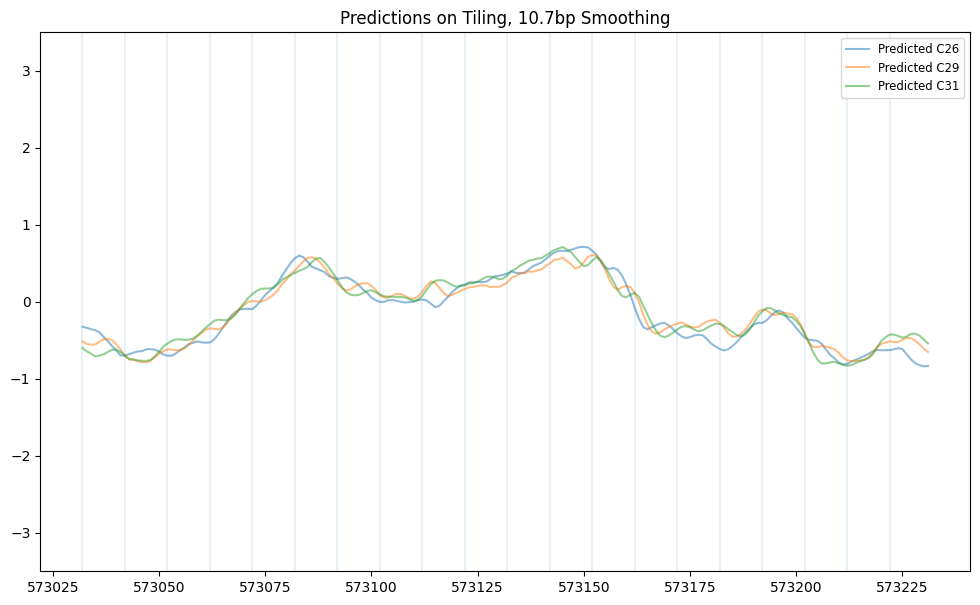

In [115]:
plt.figure(figsize=(12,7))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on Tiling, 10.7bp Smoothing")
plt.legend(fontsize="small")
plt.ylim(ylims)
plt.show()

In [178]:
# Centering which makes sense to me (dyad is at region pos 607: 607-582 = 26)
genome_df_tiling["distance_to_nucleosome"] = genome_df_tiling["region_pos"] - 582

# Centering which makes seems to put the peak at position 0:
# genome_df_tiling["distance_to_nucleosome"] = genome_df_tiling["region_pos"] - 572

In [179]:
genome_df_tiling_dist_nuc_grouped = genome_df_tiling.groupby("distance_to_nucleosome").mean(numeric_only=True)

In [180]:
genome_df_tiling_dist_nuc_grouped

,gene_number,region_pos,chr_pos,C26,C29,C31,C0_orig,n=26,n=29,n=31,...,smooth_12.9bp_cn_mean2,smooth_12.9bp_C01,smooth_12.9bp_C02,smooth_13.0bp_C26,smooth_13.0bp_C29,smooth_13.0bp_C31,smooth_13.0bp_cn_mean,smooth_13.0bp_cn_mean2,smooth_13.0bp_C01,smooth_13.0bp_C02
distance_to_nucleosome,,,,,,,,,,,,,,,,,,,,,
-582,287.5,0.0,461042.774306,NaN,NaN,NaN,NaN,-0.009562,0.050234,0.033900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-581,287.5,1.0,461043.774306,NaN,NaN,NaN,NaN,-0.026336,0.041936,0.042418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-580,287.5,2.0,461044.774306,NaN,NaN,NaN,NaN,-0.035939,0.017294,0.046395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-579,287.5,3.0,461045.774306,NaN,NaN,NaN,NaN,-0.023932,-0.001202,0.043173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-578,287.5,4.0,461046.774306,NaN,NaN,NaN,NaN,-0.006531,-0.019178,0.020095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,287.5,1000.0,462042.774306,NaN,NaN,NaN,NaN,-0.063294,-0.066947,-0.066683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,287.5,1001.0,462043.774306,NaN,NaN,NaN,NaN,-0.059247,-0.072030,-0.065621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,287.5,1002.0,462044.774306,NaN,NaN,NaN,NaN,-0.043598,-0.079432,-0.070381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
xlims_aligned=[-200, 200]
# xlims_aligned=[-400, 400]
ylims_aligned1=[-0.4, 0.4]
alpha_val_aligned = 0.5

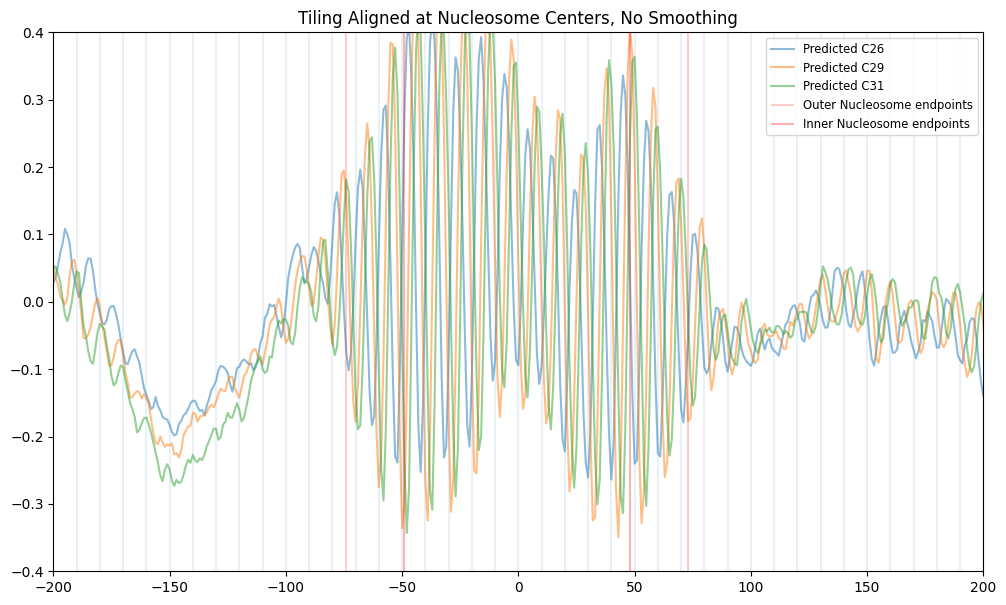

In [182]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["n=26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["n=29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["n=31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, No Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

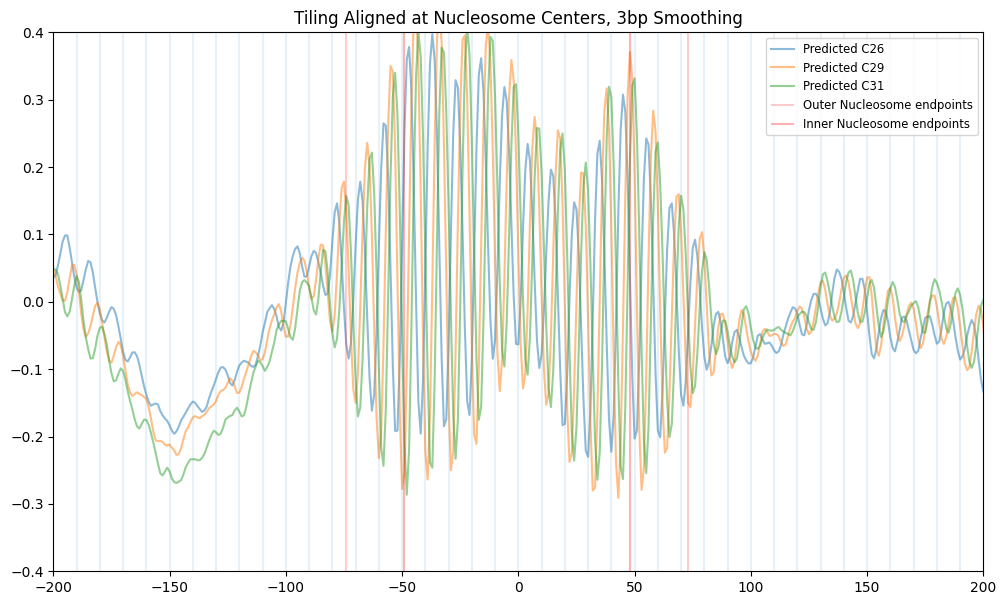

In [183]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_3bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_3bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_3bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 3bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

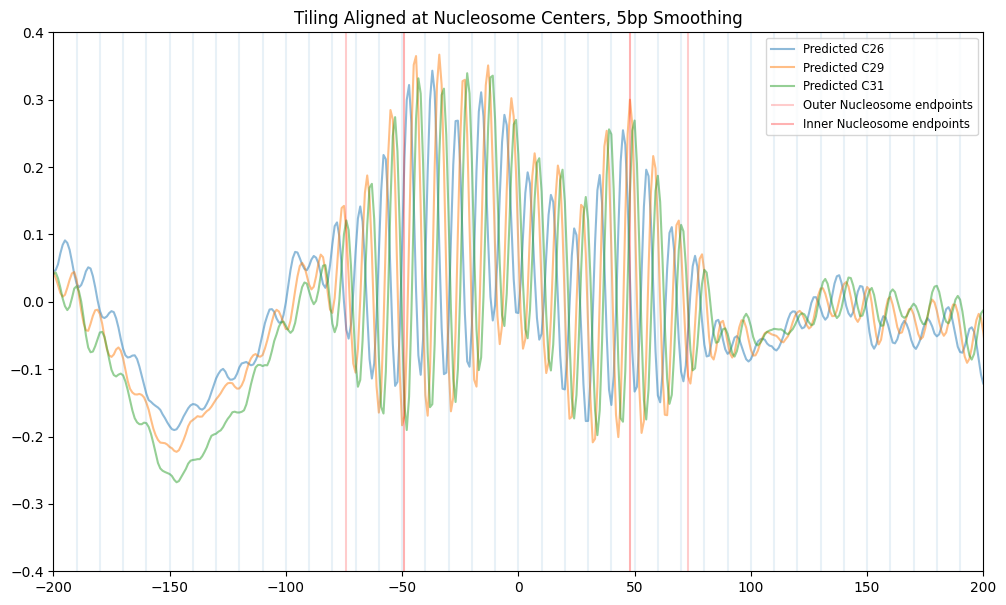

In [184]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_5bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_5bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_5bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 5bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

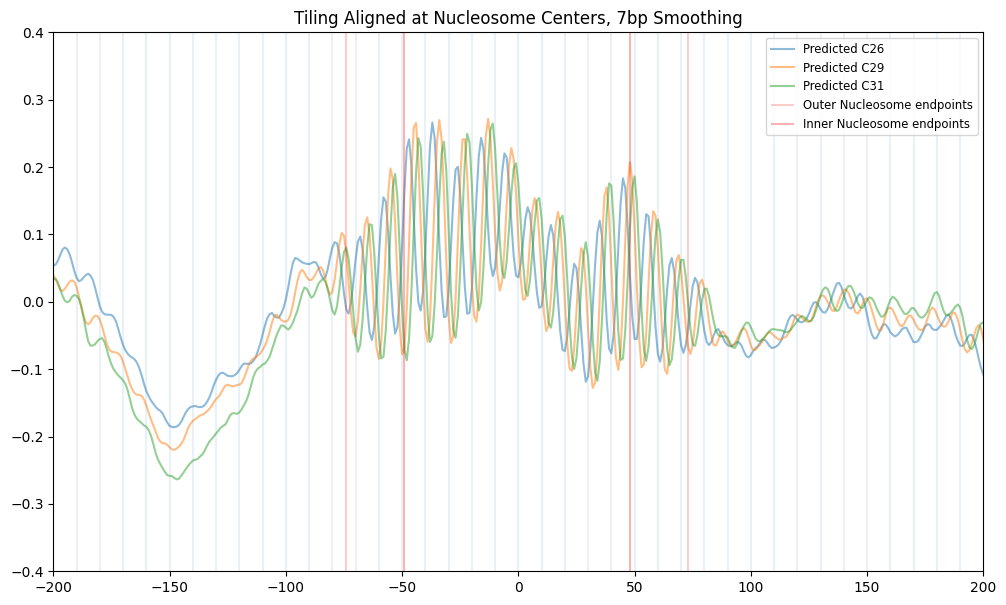

In [185]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_7bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_7bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_7bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 7bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

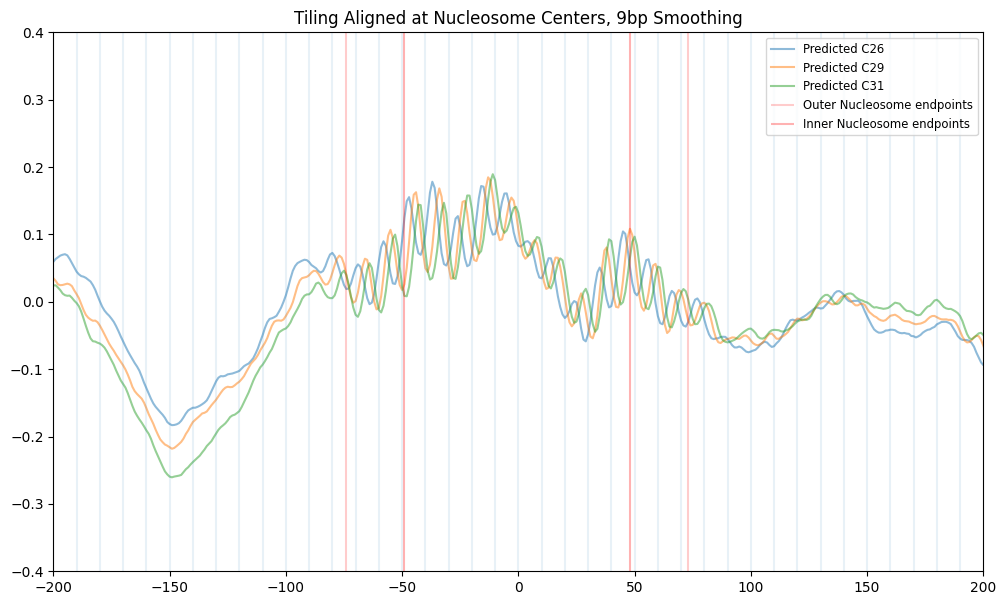

In [186]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_9bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_9bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_9bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 9bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

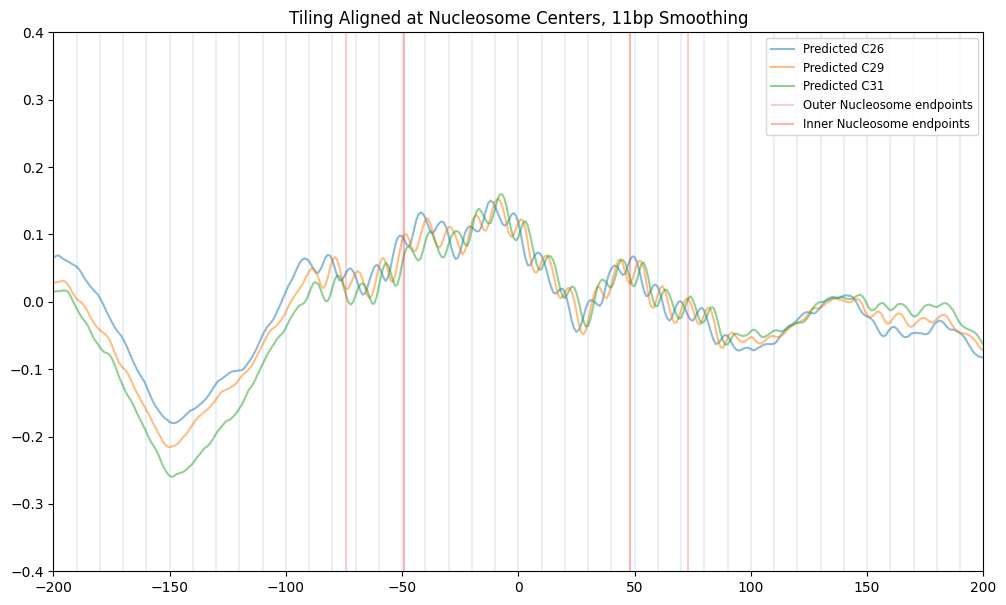

In [187]:
plt.figure(figsize=(12,7))

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_11bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_11bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_11bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 11bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

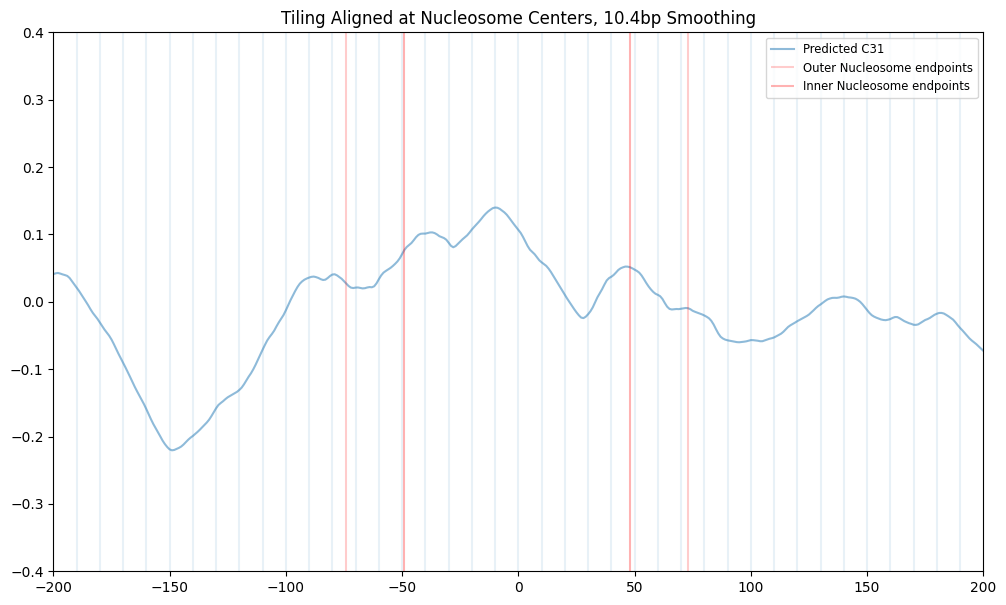

In [188]:
plt.figure(figsize=(12,7))

# plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_10.4bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_10.4bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_10.4bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

plt.plot(genome_df_tiling_dist_nuc_grouped["smooth_10.4bp_cn_mean2"], label="Predicted C31", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(xlims_aligned[0]//10, xlims_aligned[1]//10))], ylims[0], ylims[1], alpha=0.1)

plt.title("Tiling Aligned at Nucleosome Centers, 10.4bp Smoothing")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.show()

In [52]:
print(np.mean(abs(genome_df_tiling["C26"] - genome_df_tiling["smooth_10.4bp_cn_mean2"])))
print(np.mean(abs(genome_df_tiling["C29"] - genome_df_tiling["smooth_10.4bp_cn_mean2"])))
print(np.mean(abs(genome_df_tiling["C31"] - genome_df_tiling["smooth_10.4bp_cn_mean2"])))

0.3654512788082579
0.41358699080656747
0.41578532348504393


In [53]:
0.3654512788082579/0.41578532348504393

0.8789422285161622

In [189]:
genome_df_tiling.columns

Index(['sequence', 'gene_number', 'direction', 'chr', 'region_pos', 'chr_pos',
       'C26', 'C29', 'C31', 'C0_orig',
       ...
       'smooth_12.9bp_C01', 'smooth_12.9bp_C02', 'smooth_13.0bp_C26',
       'smooth_13.0bp_C29', 'smooth_13.0bp_C31', 'smooth_13.0bp_cn_mean',
       'smooth_13.0bp_cn_mean2', 'smooth_13.0bp_C01', 'smooth_13.0bp_C02',
       'distance_to_nucleosome'],
      dtype='object', length=372)

In [190]:
genome_df_tiling_to_save = genome_df_tiling[["sequence", "gene_number", "direction", "chr", "region_pos", "chr_pos", "C26", "C29", "C31", "C0", "n=26", "n=29", "n=31", 
                                                 "smooth_3bp_C26", "smooth_3bp_C29", "smooth_3bp_C31", "smooth_3bp_C01",
                                                 "smooth_5bp_C26", "smooth_5bp_C29", "smooth_5bp_C31", "smooth_5bp_C01",
                                                 "smooth_7bp_C26", "smooth_7bp_C29", "smooth_7bp_C31", "smooth_7bp_C01",
                                                 "smooth_9bp_C26", "smooth_9bp_C29", "smooth_9bp_C31", "smooth_9bp_C01",
                                                 "smooth_11bp_C26", "smooth_11bp_C29", "smooth_11bp_C31", "smooth_11bp_C01",
                                                 "smooth_10.4bp_C26", "smooth_10.4bp_C29", "smooth_10.4bp_C31", "smooth_10.4bp_C01", "smooth_10.4bp_C02", "smooth_10.4bp_cn_mean", "smooth_10.4bp_cn_mean2",
                                                 "smooth_10.7bp_C26", "smooth_10.7bp_C29", "smooth_10.7bp_C31", "smooth_10.7bp_C01", "smooth_10.7bp_C02", "smooth_10.7bp_cn_mean", "smooth_10.7bp_cn_mean2"]]

In [191]:
genome_df_tiling_to_save

,sequence,gene_number,direction,chr,region_pos,chr_pos,C26,C29,C31,C0,...,smooth_10.4bp_C02,smooth_10.4bp_cn_mean,smooth_10.4bp_cn_mean2,smooth_10.7bp_C26,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2
0,AATAAGTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAA...,0,reverse,chrVIII,0,144777,NaN,NaN,NaN,-0.576832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATAAGTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAAG...,0,reverse,chrVIII,1,144778,NaN,NaN,NaN,-0.563309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TAAGTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGA...,0,reverse,chrVIII,2,144779,NaN,NaN,NaN,-0.676323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAGTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAA...,0,reverse,chrVIII,3,144780,NaN,NaN,NaN,-0.743105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAAT...,0,reverse,chrVIII,4,144781,NaN,NaN,NaN,-0.747800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578875,TTCTTATAGAATACGTTGAAAATTAAATGTACGCGCCAAGATAAGA...,575,reverse,chrVII,1000,208546,NaN,NaN,NaN,-0.451200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578876,TCTTATAGAATACGTTGAAAATTAAATGTACGCGCCAAGATAAGAT...,575,reverse,chrVII,1001,208547,NaN,NaN,NaN,-0.332277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578877,CTTATAGAATACGTTGAAAATTAAATGTACGCGCCAAGATAAGATA...,575,reverse,chrVII,1002,208548,NaN,NaN,NaN,-0.178179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578878,TTATAGAATACGTTGAAAATTAAATGTACGCGCCAAGATAAGATAA...,575,reverse,chrVII,1003,208549,NaN,NaN,NaN,-0.102200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
genome_df_tiling_to_save.to_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/tiling_ir_lstm_cn_tiling_post_smoothed.csv", index=False)